<a href="https://colab.research.google.com/github/newu2012/ComputerVisionCourse/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8/lab7_GAN_and_other_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN in PyTorch

## Теория

Вступление

Генеративная состязательная сеть (GAN) позволяет генерировать новые изображения после демонстрации (обуения) реальных примеров.

Цель GAN - научить модель глубокого обучения фиксировать распределения тренировочных данных, чтобы мы могли генерировать новые данные из того же распределения.
Сети GAN были изобретены Яном Гудфеллоу в 2014 году. Общая модель GAN состоит из *генератора* ($G(z)$, где $z$ - некоторый стохастический вход (т.е. шумы)) и *дискриминатора* ($ D (x) $ , где $ x $ - пример реального изображения).

Задача генератора - создавать «поддельные» изображения, похожие на обучающие. Задача дискриминатора - определить, является ли выходной сигнал действительным или фейком - поддельным изображением (изображение с генератора).
Во время обучения генератор постоянно пытается перехитрить дискриминатор, генерируя все более качественные поддельные изображения, в то время как дискриминатор работает над тем, чтобы стать лучше и правильно классифицировать реальные и поддельные изображения.
Равновесие этого процесса - когда генератор генерирует идеальные подделки, которые выглядят так, как будто они пришли непосредственно из данных обучения, а дискриминатору остается всегда угадывать с 50% вероятностью, настоящий или фальшивый пример перед ним.

Первоначальная идея GAN заключалась в том, чтобы иметь минимаксную задачу для $ D $ и $ G $ ($ D $) - то есть задачу, кода дискреминатор пытается максимизировать вероятность того, что он правильно классифицирует действительные и поддельные изображения ($\log D(x)$), а $ G $ пытается минимизировать вероятность того, что $ D $ предсказывает, что его выходные данные являются поддельными ($ \log(1-D (G (z)))$).
Тогда функция потерь GAN имеет вид 
\begin{align}
\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]
\end{align}

Теоретически решение этой проблемы - это ситуация когда  $ p_g = p_ {data} $, и дискриминатор случайным образом угадывает, являются ли входные данные настоящими или поддельными. Однако теория сходимости  GAN все еще активно исследуется, и в действительности модели не всегда тренируйтесь до этого момента.


> *Примечание*. Мы будем использовать упрощенную модель из-за высокой вычислительной сложности полных моделей GAN. Данный практикум даст вам только объяснение общих принципо реализации GAN и того, как и почему работает эта модель.

> Ради экономии времени мы рекомендуем вам использовать графический процессор. Если вы работаете в Google Colab, вы можете включить его в меню мультимедиа.

! $ ^ $ *Примечание*:

Если вы используете Google Colab, можно использовать CPU или GPU.

Для изменения **среды выполнения** выберите **Изменить тип среды выполнения** в соответствующем меню.
<br> <u> <b> <Large> После экспериментов не забудьте вернуть тип среды на None (CPU). Google предоставляет графический процессор только временно. <b> <u>

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/uc14.png" width="500">
<img src="https://course.fast.ai/images/colab/04.png" width="350">


In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.utils.data import DataLoader



In [2]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML


In [3]:
"""
Determine if any GPUs are available
"""
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cuda')

In [4]:
import random
# Set random seed for reproducibility
manualSeed = 2012
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2012


## Набор данных.

In [5]:
BATCH_SIZE = 128
NOISE_SIZE = 128 #Z_NOISES
IMAGE_SIZE = 28  #IMAGE WIDHT AND HEIGHT

In [32]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                           ])

train_set = datasets.MNIST('mnist/', 
                           train     = True, 
                           download  = True, 
                           transform = transform)

dataloader = torch.utils.data.DataLoader(train_set, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True,
                                         drop_last=True)

Посмотрим на некоторые из примеров изображений

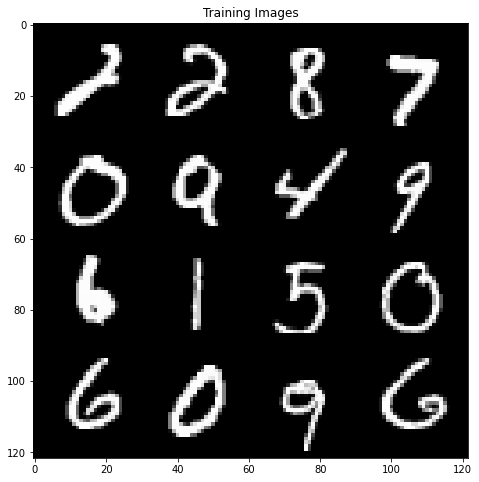

In [33]:
x_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))

plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 4,
                                         normalize=True).cpu(),
                        (1,2,0)))
plt.show()

## Реализация

### Инициалиазция весовых параметров




In [8]:
# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Архитектура модели

Генератор $ G $ отображает вектор скрытого пространства ($ z $) в пространство данных (форма изображения). <br>
Дискриминатор $ D $ представляет собой сеть бинарной классификации, которая принимает изображение на входе и выводит вероятность что входное изображение настоящее на выходе

In [9]:
def vanilla_block(in_feat, 
                  out_feat, 
                  normalize=True, 
                  activation=None):
    
    layers = []
    
    layers.append(nn.Linear(in_feat, out_feat))
    
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat))
    
    if activation: 
        layers.append(activation)
    else:
        layers.append(nn.LeakyReLU(0.2))
        
    return layers


class Generator(nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(NOISE_SIZE, 256),
            *vanilla_block(256, 512),
            *vanilla_block(512, 1024),
            *vanilla_block(1024, IMAGE_SIZE**2, 
                           normalize=False, 
                           activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        x = self.net(latent_vector_batch)
        # un-flatten (N, 1, 28, 28) shape for MNIST
        return x.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)


class Discriminator(nn.Module):
   
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(IMAGE_SIZE**2, 512, normalize=False),
            *vanilla_block(512, 256, normalize=False),
            *vanilla_block(256, 1, 
                           normalize=False, 
                           activation=nn.Sigmoid())
        )

    def forward(self, img_batch):
        # flatten from (N,1,H,W) into (N, HxW)
        x = img_batch.view(img_batch.shape[0], -1)  
        return self.net(x)

Теперь мы можем создать экземпляр генератора и дискриминатора и применить функцию `weights_init`. Посмотрите на модель, чтобы увидеть, как она устроена.

In [10]:
# Create the generator
G = Generator().to(DEVICE)

# # Handle multi-gpu if desired
# if (DEVICE.type == 'cuda') and (ngpu > 1):
#     G = nn.DataParallel(G, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
G.apply(weights_init)

# Print the model
print(G)

Generator(
  (net): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)


In [11]:
# Create the Discriminator
D = Discriminator().to(DEVICE)

# # Handle multi-gpu if desired
# if (DEVICE.type == 'cuda') and (ngpu > 1):
#     D = nn.DataParallel(D, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
D.apply(weights_init)

# Print the model
print(D)

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### Функции потерь и оптимизация

Мы можем указать, как изучать $ D $ и $ G $ с помощью функций потерь и оптимизатора. Мы будем использовать функцию бинарной взаимной энтропии, которая определена в PyTorch как:
\begin{align}
  \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, 
  \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]
\end{align}

> *Примечание*. Эта функция позволяет рассчитыать как $log(D(x))$ так и 
$log(1-D[G(z)])$ путем спецификации $y$ и $x$.

Также нам нужно определить реальное изображение как метку "1" и фальшивку как метку "0".
Наконец, мы настроим отдельные оптимизаторы для $ D $ и  $ G $.



In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()



# Learning rate for optimizers
lr = 0.0002

# Beta hyperparams for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

Для единообразция теста давайте создадим батч скрытых векторов. Мы будем использовать данный батч для визуализации.

In [13]:
fixed_noise = torch.randn(16, NOISE_SIZE, device=DEVICE)

def generate_samples(G, z_noise = fixed_noise):
    #instead of G.eval() due to recomendations
    #of using same config for batchnorm and droput 
    #in the eval for GAN
    with torch.no_grad(): 
        z = G(z_noise).detach().cpu()
    return z

Установим метки батчей

In [14]:
labels_x = torch.ones( BATCH_SIZE).to(DEVICE) # Discriminator Label to real
labels_z = torch.zeros(BATCH_SIZE).to(DEVICE) # Discriminator Label to fake

Тренировка





In [15]:
# Training Loop
EPOCHS = 10

In [16]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    
    # For each batch in the dataloader
    for idx, (images,_) in enumerate(dataloader):
        ############################
        # 1. Train D network: maximize log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()
        G.zero_grad()
        
        ###########################
        # 1 Train D network with real images 

        # 1.1 Format batch and labels
        x = images.to(DEVICE)
        b_size = x.size(0) # to train if not full batch

        # 1.2 Forward pass real batch through D
        output = D(x).view(-1)
        
        # 1.3 Calculate loss on real batch
        Loss_D_x = criterion(output, labels_x[:b_size])
        
        # 1.4 Calculate gradients for D (backward pass)
        Loss_D_x.backward()

        ####################################
        # 2 Train with fake batch
        # 2.1 Generate batch of latent vectors
        z_noise = torch.randn(b_size, NOISE_SIZE, device=DEVICE)
        
        # 2.2 Generate fake image batch with G
        z = G(z_noise)
        
        # 2.3 Classify fake images batch with D(G(z_noise))
        output = D(z.detach()).view(-1)
        
        # 2.4 Calculate D loss on the fake batch
        Loss_D_z = criterion(output, labels_z[:b_size])
        
        # 2.5 Calculate the gradients for fake batch, 
        Loss_D_z.backward()
        
        ########################################
        # 2.7 Compute error of D as sum over the fake and the real batches
        Loss_D = Loss_D_x + Loss_D_z
        
        # 2.8 Update Discrimenator weights
        optimizerD.step()

        ############################
        # 3. Update G network: maximize log(D(G(z)))
        
        ###########################
        # 3.1 Since updating D, another forward pass of fake batch through D
        output = D(z).view(-1)
        
        # 3.2 Calculate G's loss based on this output
        Loss_G = criterion(output, labels_x[:b_size])
        
        # 3.3 Calculate gradients for G
        Loss_G.backward()
        
        # 3.4 Update G
        optimizerG.step()
        
        ########################################
        # 4. Auxiliary part

        # 4.1 Output training stats
        if idx % 50 == 0:
            print("""[%d/%d][%d/%d]\t Loss_D:%.4f\t Loss_G:%.4f\t"""
                  % (epoch, EPOCHS, 
                     idx,len(dataloader),
                     Loss_D.item(), 
                     Loss_G.item()))

        # 4.2 Save Losses for plotting later
        G_losses.append(Loss_G.item())
        D_losses.append(Loss_D.item())

        # 4.3 Check how the generator is doing by saving G's output on fixed_noise
        if (idx % 500 == 0) or (
            (epoch == EPOCHS-1) and (idx == len(dataloader)-1)
        ):
            z = generate_samples(G)
            img_list.append(vutils.make_grid(z, padding=2, normalize=True))


Starting Training Loop...
[0/10][0/468]	 Loss_D:1.3232	 Loss_G:0.7268	
[0/10][50/468]	 Loss_D:1.3644	 Loss_G:0.7995	
[0/10][100/468]	 Loss_D:1.1661	 Loss_G:1.0487	
[0/10][150/468]	 Loss_D:1.4453	 Loss_G:0.6954	
[0/10][200/468]	 Loss_D:1.2175	 Loss_G:1.0603	
[0/10][250/468]	 Loss_D:1.3147	 Loss_G:0.5965	
[0/10][300/468]	 Loss_D:1.2968	 Loss_G:0.8428	
[0/10][350/468]	 Loss_D:1.2699	 Loss_G:0.8613	
[0/10][400/468]	 Loss_D:1.3012	 Loss_G:0.9111	
[0/10][450/468]	 Loss_D:1.2750	 Loss_G:0.5588	
[1/10][0/468]	 Loss_D:1.2891	 Loss_G:0.8719	
[1/10][50/468]	 Loss_D:1.2235	 Loss_G:0.7729	
[1/10][100/468]	 Loss_D:1.2942	 Loss_G:1.0245	
[1/10][150/468]	 Loss_D:1.4492	 Loss_G:0.5028	
[1/10][200/468]	 Loss_D:1.2323	 Loss_G:0.7896	
[1/10][250/468]	 Loss_D:1.2691	 Loss_G:0.8814	
[1/10][300/468]	 Loss_D:1.2084	 Loss_G:0.6217	
[1/10][350/468]	 Loss_D:1.5321	 Loss_G:1.6826	
[1/10][400/468]	 Loss_D:1.2853	 Loss_G:1.0412	
[1/10][450/468]	 Loss_D:1.2161	 Loss_G:0.9866	
[2/10][0/468]	 Loss_D:1.4064	 Loss_G:1.2

## Оценка результатов

**Потери по итерациям обучения** <br>
Ниже приведен график потерь D и G в зависимости от итераций обучения. 




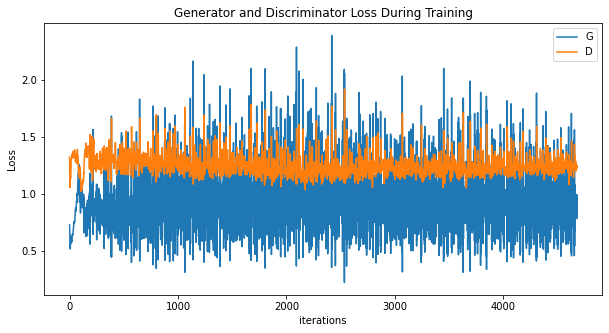

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



**Визуализация прогресса генератора** <br>
Мы можем визуализировать процесс обучения `G` с помощью анимации. <br>
Нажмите кнопку воспроизведения, чтобы начать анимацию. 




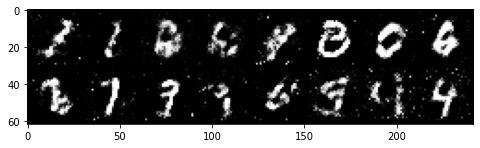

In [18]:
#%%capture
fig = plt.figure(figsize=(8,8))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Настоящие изображения и поддельные изображения** <br>
Наконец, давайте посмотрим на несколько реальных и поддельных изображений.





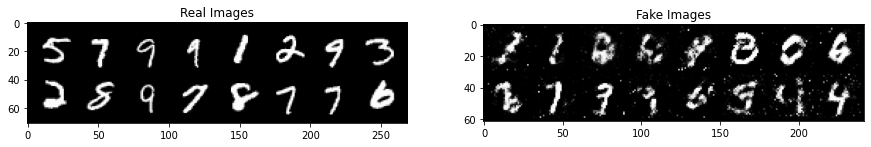

In [19]:
# Grab a batch of real images from the dataloader
x_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)

plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 8,
                                         padding=5, 
                                         normalize=True).cpu(),
                        (1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)

plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [21]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)
    
# Saving params.
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : optimizerD.state_dict()}, 'D.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : optimizerG.state_dict()}, 'G.pth.tar')    

## Упражнение 1
1. Попробуйте обучить GAN работе с набором данных Fashion MNIST (`datasets.FashionMNIST ()`).
2. Попробуйте создать GAN на основе сверток вместо текущей версии с полносвязными слоями.


### Упражнение 1.1
Попробуйте обучить GAN работе с набором данных Fashion MNIST (datasets.FashionMNIST ()).

#### Настройка

In [31]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                           ])

train_set = datasets.FashionMNIST('fashion_mnist/', 
                           train     = True, 
                           download  = True, 
                           transform = transform)

dataloader = torch.utils.data.DataLoader(train_set, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True,
                                         drop_last=True)

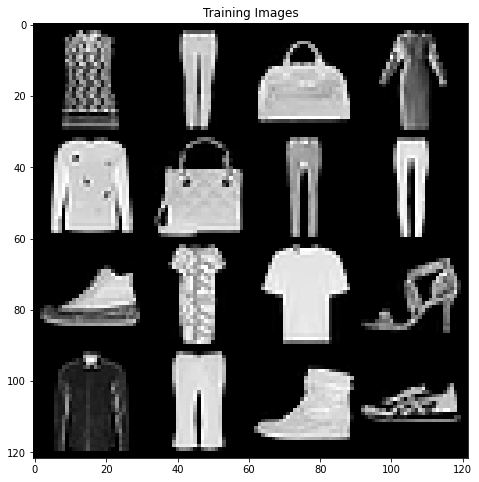

In [97]:
x_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))

plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 4,
                                         normalize=True).cpu(),
                        (1,2,0)))
plt.show()

In [98]:
# Create the generator
G = Generator().to(DEVICE)
# Apply the weights_init function to randomly initialize all weights
G.apply(weights_init)
# Print the model
print(G)

# Create the Discriminator
D = Discriminator().to(DEVICE)
# Apply the weights_init function to randomly initialize all weights
D.apply(weights_init)
# Print the model
print(D)

Generator(
  (net): Sequential(
    (0): Linear(in_features=140, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (last): Sequential(
    (0): Linear(in_features=256, out_featur

In [99]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Learning rate for optimizers
lr = 0.0002

# Beta hyperparams for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

In [100]:
fixed_noise = torch.randn(16, NOISE_SIZE, device=DEVICE)

labels_x = torch.ones( BATCH_SIZE).to(DEVICE) # Discriminator Label to real
labels_z = torch.zeros(BATCH_SIZE).to(DEVICE) # Discriminator Label to fake

#### Обучение

In [ ]:
# Training Loop
EPOCHS = 10

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    
    # For each batch in the dataloader
    for idx, (images,_) in enumerate(dataloader):
        ############################
        # 1. Train D network: maximize log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()
        G.zero_grad()
        
        ###########################
        # 1 Train D network with real images 

        # 1.1 Format batch and labels
        x = images.to(DEVICE)
        b_size = x.size(0) # to train if not full batch

        # 1.2 Forward pass real batch through D
        output = D(x).view(-1)
        
        # 1.3 Calculate loss on real batch
        Loss_D_x = criterion(output, labels_x[:b_size])
        
        # 1.4 Calculate gradients for D (backward pass)
        Loss_D_x.backward()

        ####################################
        # 2 Train with fake batch
        # 2.1 Generate batch of latent vectors
        z_noise = torch.randn(b_size, NOISE_SIZE, device=DEVICE)
        
        # 2.2 Generate fake image batch with G
        z = G(z_noise)
        
        # 2.3 Classify fake images batch with D(G(z_noise))
        output = D(z.detach()).view(-1)
        
        # 2.4 Calculate D loss on the fake batch
        Loss_D_z = criterion(output, labels_z[:b_size])
        
        # 2.5 Calculate the gradients for fake batch, 
        Loss_D_z.backward()
        
        ########################################
        # 2.7 Compute error of D as sum over the fake and the real batches
        Loss_D = Loss_D_x + Loss_D_z
        
        # 2.8 Update Discrimenator weights
        optimizerD.step()

        ############################
        # 3. Update G network: maximize log(D(G(z)))
        
        ###########################
        # 3.1 Since updating D, another forward pass of fake batch through D
        output = D(z).view(-1)
        
        # 3.2 Calculate G's loss based on this output
        Loss_G = criterion(output, labels_x[:b_size])
        
        # 3.3 Calculate gradients for G
        Loss_G.backward()
        
        # 3.4 Update G
        optimizerG.step()
        
        ########################################
        # 4. Auxiliary part

        # 4.1 Output training stats
        if idx % 50 == 0:
            print("""[%d/%d][%d/%d]\t Loss_D:%.4f\t Loss_G:%.4f\t"""
                  % (epoch, EPOCHS, 
                     idx,len(dataloader),
                     Loss_D.item(), 
                     Loss_G.item()))

        # 4.2 Save Losses for plotting later
        G_losses.append(Loss_G.item())
        D_losses.append(Loss_D.item())

        # 4.3 Check how the generator is doing by saving G's output on fixed_noise
        if (idx % 500 == 0) or (
            (epoch == EPOCHS-1) and (idx == len(dataloader)-1)
        ):
            z = generate_samples(G)
            img_list.append(vutils.make_grid(z, padding=2, normalize=True))


#### Результаты

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
x_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)

plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 8,
                                         padding=5, 
                                         normalize=True).cpu(),
                        (1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)

plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Saving params.
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : optimizerD.state_dict()}, 'D.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : optimizerG.state_dict()}, 'G.pth.tar')    

### Упражнение 1.2
Попробуйте создать GAN на основе сверток вместо текущей версии с полносвязными слоями.

#### Настройка

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                           ])

train_set = datasets.FashionMNIST('fashion_mnist/', 
                           train     = True, 
                           download  = True, 
                           transform = transform)

dataloader = torch.utils.data.DataLoader(train_set, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True,
                                         drop_last=True)

In [ ]:
x_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))

plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 4,
                                         normalize=True).cpu(),
                        (1,2,0)))
plt.show()

##### (((

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(NOISE_SIZE, 256, 1, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(256, 512, 1, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(512, 1024, 1, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(1024, IMAGE_SIZE**2, 1, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(IMAGE_SIZE**2, 512, 1, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(512, 256, 1, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(256, 1, 1, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
G = Generator().to(DEVICE)
# Apply the weights_init function to randomly initialize all weights
G.apply(weights_init)
# Print the model
print(G)

# Create the Discriminator
D = Discriminator().to(DEVICE)
# Apply the weights_init function to randomly initialize all weights
D.apply(weights_init)
# Print the model
print(D)

##### Mda

In [ ]:
def vanilla_block(in_feat, 
                  out_feat,
                  transpose=True,
                  normalize=True, 
                  activation=None):
    
    layers = []
    if transpose:
        layers.append(nn.ConvTranspose2d(in_feat, out_feat, 1))
    else:
        layers.append(nn.Conv2d(in_feat, out_feat, 1))

    if normalize:
        layers.append(nn.BatchNorm2d(out_feat))
    if activation: 
        layers.append(activation)
        print(layers)
    else:
        layers.append(nn.LeakyReLU(0.2))

    return layers

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(NOISE_SIZE, 256),
            *vanilla_block(256, 512),
            *vanilla_block(512, 1024),
            *vanilla_block(1024, IMAGE_SIZE**2, 
                           normalize=False, 
                           activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        x = self.net(latent_vector_batch)
        # un-flatten (N, 1, 28, 28) shape for MNIST
        return x.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(IMAGE_SIZE**2, 512, transpose=False, 
                           normalize=False),
            *vanilla_block(512, 256, transpose=False, normalize=False),
            *vanilla_block(256, 1, transpose=False,
                           normalize=False, 
                           activation=nn.Sigmoid())
        )

    def forward(self, img_batch):
        # flatten from (N,1,H,W) into (N, HxW)
        x = img_batch.view(img_batch.shape[0], -1)  
        return self.net(x)

In [ ]:
# Create the generator
G = Generator().to(DEVICE)
# Apply the weights_init function to randomly initialize all weights
G.apply(weights_init)
# Print the model
print(G)

# Create the Discriminator
D = Discriminator().to(DEVICE)
# Apply the weights_init function to randomly initialize all weights
D.apply(weights_init)
# Print the model
print(D)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Learning rate for optimizers
lr = 0.0002

# Beta hyperparams for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
fixed_noise = torch.randn(16, NOISE_SIZE, device=DEVICE)

labels_x = torch.ones(BATCH_SIZE).to(DEVICE) # Discriminator Label to real
labels_z = torch.zeros(BATCH_SIZE).to(DEVICE) # Discriminator Label to fake

#### Обучение

In [ ]:
# Training Loop
EPOCHS = 10

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    
    # For each batch in the dataloader
    for idx, (images,_) in enumerate(dataloader):
        ############################
        # 1. Train D network: maximize log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()
        G.zero_grad()
        
        ###########################
        # 1 Train D network with real images 

        # 1.1 Format batch and labels
        x = images.to(DEVICE)
        b_size = x.size(0) # to train if not full batch

        # 1.2 Forward pass real batch through D
        output = D(x).view(-1)
        
        # 1.3 Calculate loss on real batch
        Loss_D_x = criterion(output, labels_x[:b_size])
        
        # 1.4 Calculate gradients for D (backward pass)
        Loss_D_x.backward()

        ####################################
        # 2 Train with fake batch
        # 2.1 Generate batch of latent vectors
        z_noise = torch.randn(b_size, NOISE_SIZE, device=DEVICE)
        
        # 2.2 Generate fake image batch with G
        z = G(z_noise)
        
        # 2.3 Classify fake images batch with D(G(z_noise))
        output = D(z.detach()).view(-1)
        
        # 2.4 Calculate D loss on the fake batch
        Loss_D_z = criterion(output, labels_z[:b_size])
        
        # 2.5 Calculate the gradients for fake batch, 
        Loss_D_z.backward()
        
        ########################################
        # 2.7 Compute error of D as sum over the fake and the real batches
        Loss_D = Loss_D_x + Loss_D_z
        
        # 2.8 Update Discrimenator weights
        optimizerD.step()

        ############################
        # 3. Update G network: maximize log(D(G(z)))
        
        ###########################
        # 3.1 Since updating D, another forward pass of fake batch through D
        output = D(z).view(-1)
        
        # 3.2 Calculate G's loss based on this output
        Loss_G = criterion(output, labels_x[:b_size])
        
        # 3.3 Calculate gradients for G
        Loss_G.backward()
        
        # 3.4 Update G
        optimizerG.step()
        
        ########################################
        # 4. Auxiliary part

        # 4.1 Output training stats
        if idx % 50 == 0:
            print("""[%d/%d][%d/%d]\t Loss_D:%.4f\t Loss_G:%.4f\t"""
                  % (epoch, EPOCHS, 
                     idx,len(dataloader),
                     Loss_D.item(), 
                     Loss_G.item()))

        # 4.2 Save Losses for plotting later
        G_losses.append(Loss_G.item())
        D_losses.append(Loss_D.item())

        # 4.3 Check how the generator is doing by saving G's output on fixed_noise
        if (idx % 500 == 0) or (
            (epoch == EPOCHS-1) and (idx == len(dataloader)-1)
        ):
            z = generate_samples(G)
            img_list.append(vutils.make_grid(z, padding=2, normalize=True))


# CONDITIONAL И INFO GAN

Основная проблема показанного выше обычного GAN - это высокая вероятность переобучения из-за отсутствия какой-либо дополнительной информации об изображении. Это позволяет использовать GAN без учителя. Однако, если у вас есть нужная информация, вы можете использовать ее для повышения производительности GAN. Для этого можно применить два основных подхода. <ul>
     <li> Условный (conditional) GAN - этот подход позволяет учесть требуемый класс изображения, используя дополнительный вектор объедененный (конкатинированный) с шумовым (скрытым) пространством GAN.
     <li> Info GAN позволяет прогнозировать класс изображения (дискретное распределение) и его конкретные параметры (распределения) в дополнение к принятию решений о реальном/фальшивом изображении. Другими словами, InfoGan разделяет входные данные генератора на две части: обычный вектор шума и новый вектор «скрытого кода». Затем коды становятся значимыми, максимизируя взаимную информацию между кодом и выходом генератора. Эту взаимную информацию можно применить в качестве регуляризационного фактора в функции потерь.
        \begin{align}
        \underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = 
        \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + 
        \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z,c)))\big] -
        \lambda Q(c,G(z,c)),
        \end{align}
      где $Q(c,G(z,c))$ это дополнительная сеть для классификации.
        
![](https://habrastorage.org/r/w1560/web/3bf/bba/cdd/3bfbbacddcba4603b71c94dff48753e3.png)
 

![image.png](attachment:ce71bff2-597b-4a4c-9d0d-da98a4cd6960.png)

## Упражнение 2.
1. Изучите примеры условного (Conditional) и информационного(Info) GAN ниже.
2. Добавьте комментарии к ним о том, как они работают, и где их можно или нельзя применять.

Так как не получается заставить сети работать придётся только рассказывать как понял.
Conditional GAN - GAN, к которому добавили на вход в генератор и дискриминатор название изображения (его группа). Так генератор сможет попробовать сгенерировать картинку нужного типа, а дискриминатор мог лучше понять что будет изображено (как это работает с дискриминатором я не понял).
InfoGAN - GAN, на вход в генератор добавили которому набор фич (я так понял вероятность принадлежности к группам), и на выходе из дискриминатора выходит тот же набор фич. То есть обучение ведётся в сторону совпадения вероятностного распределения по фичам между генератором и дискриминатором. 

## Conditional GAN

In [20]:
CONDITION_SIZE = 10

In [21]:
def to_onehot(x):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    
    if isinstance(x, int):
        c = torch.zeros(1, CONDITION_SIZE).long()
        c[0][x] = 1
    
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), CONDITION_SIZE)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [22]:
fixed_noise = torch.randn(16, NOISE_SIZE, device=DEVICE)
fixed_c     = torch.zeros([16, CONDITION_SIZE]).to(DEVICE)

def generate_samples(G, z_noise = fixed_noise):
    #instead of G.eval() due to recomendations
    #of using same config for batchnorm and droput 
    #in the eval for GAN
    with torch.no_grad(): 
        z = G(z_noise,fixed_c).detach().cpu()
    return z

In [23]:
class Discriminator(nn.Module):
   
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(IMAGE_SIZE**2+CONDITION_SIZE, 512, normalize=False),
            *vanilla_block(512, 256, normalize=False),
            *vanilla_block(256, 1, 
                           normalize=False, 
                           activation=nn.Sigmoid())
        )

    def forward(self, img_batch, condition):
        
        # flatten from (N,1,H,W) into (N, HxW)
        x = img_batch.view(img_batch.shape[0], -1)  
        # flatten condition into (N, c)
        c = condition.view(condition.size(0), -1).float()
        # create new vector
        # v: [input, label] concatenated vector
        v = torch.cat((x, c), 1) 
        return self.net(v)

In [24]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(NOISE_SIZE+CONDITION_SIZE, 256),
            *vanilla_block(256, 512),
            *vanilla_block(512, 1024),
            *vanilla_block(1024, IMAGE_SIZE**2, 
                           normalize=False, 
                           activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch, condition):
        # check if input vector
        y = latent_vector_batch.view(latent_vector_batch.size(0), -1)
        # check if condition vector
        c = condition.view(condition.size(0), -1).float()
        # v: [input, label] concatenated vector
        v = torch.cat((y, c), 1) 
        # make forward pass
        x = self.net(v)
        # un-flatten (N, 1, 28, 28) shape for MNIST
        return x.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE) 

In [25]:
# Create the Discriminator
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
 
# Apply the weights_init function to randomly initialize all weights
D.apply(weights_init)
G.apply(weights_init)

# Print the model
print(D)
print(G)

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Generator(
  (net): Sequential(
    (0): Linear(in_features=138, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10

In [26]:
labels_x = labels_x.view(-1,1)
labels_z = labels_z.view(-1,1)

In [27]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

for epoch in range(EPOCHS):
    for idx, (images, labels) in enumerate(dataloader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(BATCH_SIZE, 1)
        y = to_onehot(y).to(DEVICE)
      
        x_outputs = D(x, y)
        Loss_D_x = criterion(x_outputs, labels_x)

        z_noise = torch.randn(BATCH_SIZE, NOISE_SIZE).to(DEVICE)
        z_outputs = D(G(z_noise, y), y)
        Loss_D_z = criterion(z_outputs, labels_z)
        Loss_D = Loss_D_x + Loss_D_z
        
        D.zero_grad()
        Loss_D.backward()
        optimizerD.step()
        
       
        # Training Generator
        z = torch.randn(BATCH_SIZE, NOISE_SIZE).to(DEVICE)
        z_outputs = D(G(z, y), y)
        Loss_G = criterion(z_outputs, labels_x)

        G.zero_grad()
        Loss_G.backward()
        optimizerG.step()
    
        ########################################
        # 4. Auxiliary part

        # 4.1 Output training stats
        if idx % 50 == 0:
            print("""[%d/%d][%d/%d]\t Loss_D:%.4f\t Loss_G:%.4f\t"""
                  % (epoch, EPOCHS, 
                     idx,len(dataloader),
                     Loss_D.item(), 
                     Loss_G.item()))

        # 4.2 Save Losses for plotting later
        G_losses.append(Loss_G.item())
        D_losses.append(Loss_D.item())

        # 4.3 Check how the generator is doing by saving G's output on fixed_noise
        if (idx % 500 == 0) or (
            (epoch == EPOCHS-1) and (idx == len(dataloader)-1)
        ):
            z = generate_samples(G)
            img_list.append(vutils.make_grid(z, padding=2, normalize=True))

[0/10][0/468]	 Loss_D:1.3920	 Loss_G:0.6870	
[0/10][50/468]	 Loss_D:1.3911	 Loss_G:0.6875	
[0/10][100/468]	 Loss_D:1.3881	 Loss_G:0.6859	
[0/10][150/468]	 Loss_D:1.3918	 Loss_G:0.6871	
[0/10][200/468]	 Loss_D:1.3918	 Loss_G:0.6863	
[0/10][250/468]	 Loss_D:1.3923	 Loss_G:0.6875	
[0/10][300/468]	 Loss_D:1.3929	 Loss_G:0.6866	
[0/10][350/468]	 Loss_D:1.3908	 Loss_G:0.6874	
[0/10][400/468]	 Loss_D:1.3920	 Loss_G:0.6866	
[0/10][450/468]	 Loss_D:1.3903	 Loss_G:0.6870	
[1/10][0/468]	 Loss_D:1.3905	 Loss_G:0.6870	
[1/10][50/468]	 Loss_D:1.3926	 Loss_G:0.6869	
[1/10][100/468]	 Loss_D:1.3923	 Loss_G:0.6872	
[1/10][150/468]	 Loss_D:1.3923	 Loss_G:0.6873	
[1/10][200/468]	 Loss_D:1.3934	 Loss_G:0.6873	
[1/10][250/468]	 Loss_D:1.3931	 Loss_G:0.6871	
[1/10][300/468]	 Loss_D:1.3918	 Loss_G:0.6875	
[1/10][350/468]	 Loss_D:1.3896	 Loss_G:0.6869	
[1/10][400/468]	 Loss_D:1.3939	 Loss_G:0.6870	
[1/10][450/468]	 Loss_D:1.3932	 Loss_G:0.6879	
[2/10][0/468]	 Loss_D:1.3896	 Loss_G:0.6872	
[2/10][50/468]	 Loss_

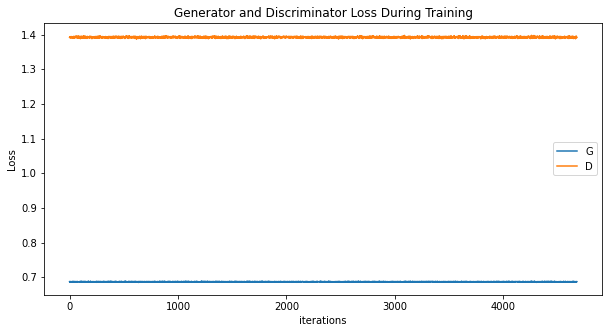

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

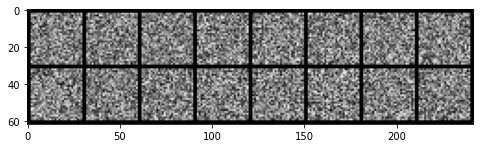

In [29]:
#%%capture
fig = plt.figure(figsize=(8,8))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

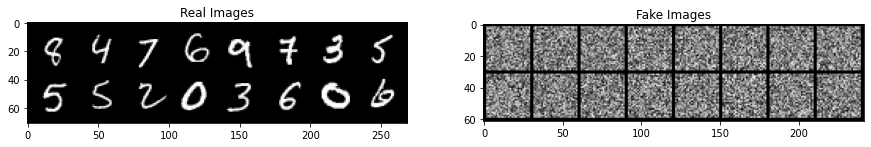

In [30]:
# Grab a batch of real images from the dataloader
x_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)

plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 8,
                                         padding=5, 
                                         normalize=True).cpu(),
                        (1,2,0)))


# Plot the fake images from the last epoch
plt.subplot(1,2,2)

plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Info GAN

In [34]:
class Discriminator(nn.Module):
   
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(IMAGE_SIZE**2, 512, normalize=False),
            *vanilla_block(512, 256, normalize=False),
        )
        
        self.last = nn.Sequential(
             *vanilla_block(256, 1, 
                           normalize=False, 
                           activation=nn.Sigmoid())
        )

    def forward(self, img):
        x = img.view(img.shape[0], -1)  
        
        # return with top layer features for Q
        features = self.net(x)
        
        y = self.last(features) # Real / Fake
        
        return y, features

In [35]:
CODE_SIZE = 12

class Generator(nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.net = nn.Sequential(
            *vanilla_block(NOISE_SIZE+CODE_SIZE, 256),
            *vanilla_block(256, 512),
            *vanilla_block(512, 1024),
            *vanilla_block(1024, IMAGE_SIZE**2, 
                           normalize=False, 
                           activation=nn.Tanh())
        )

    def forward(self, latent_vector, code):
        
        # check if input vector
        y = latent_vector.view(latent_vector.size(0), -1)
        
        # check if code vector
        c = code.view(code.size(0), -1).float()
        
        # v: [input, label] concatenated vector
        v = torch.cat((y, c), 1) 
        
        # make forward pass
        x = self.net(v)
        
        # un-flatten (N, 1, 28, 28) shape for MNIST
        return x.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE) 

In [36]:
CLASSES = 10

class Qrator(nn.Module):
    """
        Regularization Network for increasing Mutual Information
    """
    def __init__(self):
        super(Qrator, self).__init__()
        self.fc = nn.Sequential(
                    *vanilla_block(256, 128),
                     nn.Linear(128, CLASSES+4),
                )
        
    def forward(self, x):
        # Seperate code
        c = self.fc(x)
        c_discrete = torch.softmax(c[:, :CLASSES], dim=-1) # Digit Label {0~9}
        c_mu = c[:, 10:12] # mu & var of Rotation & Thickness
        c_var = c[:, 12:14].exp() # mu & var of Rotation & Thickness
        return c_discrete, c_mu, c_var

In [37]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
Q = Qrator().to(DEVICE)

In [52]:
def sample_noise(n_c_discrete, n_c_continuous, label=None):
    
    z = torch.randn(BATCH_SIZE, NOISE_SIZE).to(DEVICE)
    
    #if label:
    if True:
        c_discrete = to_onehot(label).to(DEVICE) # (B,10)
    else:
        c_discrete = to_onehot(torch.LongTensor(BATCH_SIZE, 1).random_(0, n_c_discrete)).to(DEVICE) # (B,10)
    
    c_continuous = torch.zeros(BATCH_SIZE, n_c_continuous).uniform_(-1, 1).to(DEVICE) # (B,2)
    
    c = torch.cat((c_discrete.float(), c_continuous), 1)
    
    return z, c

In [39]:
bce_loss = nn.BCELoss()
ce_loss  = nn.CrossEntropyLoss()

In [40]:
def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)

In [41]:
n_c_discrete, n_c_continuous = CLASSES, 2

In [53]:
G_losses = []
D_losses = []
GnQ_losses = []

for epoch in range(EPOCHS):
    for idx, (images, labels) in enumerate(dataloader):

        labels = labels.view(BATCH_SIZE, 1)
        
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs, _, = D(x)
        D_x_loss = bce_loss(x_outputs, labels_x)

        z, c = sample_noise(n_c_discrete, n_c_continuous, label=labels)
        z_outputs, _, = D(G(z, c))
        D_z_loss = bce_loss(z_outputs, labels_z)
        D_loss = D_x_loss + D_z_loss
        
        optimizerD.zero_grad()
        D_loss.backward()
        optimizerD.step()

        # Training Generator
        z, c = sample_noise(n_c_discrete, n_c_continuous, label=labels)
        c_discrete_label = torch.max(c[:, :-2], 1)[1].view(-1, 1)

        z_outputs, features = D(G(z, c)) 
        c_discrete_out, cc_mu, cc_var = Q(features)

        G_loss = bce_loss(z_outputs, labels_x)
        Q_loss_discrete = ce_loss(c_discrete_out, c_discrete_label.view(-1))
        
        Q_loss_continuous = -torch.mean(torch.sum(log_gaussian(c[:, -2:], cc_mu, cc_var), 1)) # N(x | mu,var) -> (B, 2) -> (,1)
        
        mutual_info_loss = Q_loss_discrete + Q_loss_continuous*0.1

        GnQ_loss = G_loss + mutual_info_loss

        optimizerG.zero_grad()
        GnQ_loss.backward()
        optimizerG.step()

        # Auxiliary part
        if idx % 50 == 0:
            print("""[%d/%d][%d/%d]\t Loss_D:%.4f\t Loss_G:%.4f\t"""
                  % (epoch, EPOCHS, 
                     idx,len(dataloader),
                     G_loss.item(), 
                     D_loss.item()))

        # 4.2 Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        GnQ_losses.append(GnQ_loss.item())

        # 4.3 Check how the generator is doing by saving G's output on fixed_noise
        if (idx % 500 == 0) or (
            (epoch == EPOCHS-1) and (idx == len(dataloader)-1)
        ):
            z = generate_samples(G)
            img_list.append(vutils.make_grid(z, padding=2, normalize=True))

[0/10][0/468]	 Loss_D:0.6746	 Loss_G:1.3783	


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
x_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)

plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(x_batch[0].to(DEVICE)[:16], 
                                         nrow = 8,
                                         padding=5, 
                                         normalize=True).cpu(),
                        (1,2,0)))


# Plot the fake images from the last epoch
plt.subplot(1,2,2)

plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()